# Experiments with Triplet Loss for Finding Lower-Dimensional Embedding of GMMs

## Set-Up

### Data
The data comes from a Gaussian mixture over 'k' different components. 

More concretely, there are $k$ hidden components  $v_1, v_2,\dots,  v_{k}$ part of a $d_k$-dimensional subspace of $\mathbb{R^d}.$ For now, we take them to be standard Gaussian in the first $d_k$ coordinates 
 
There is also a distribution with marginals $p[1], p[2], \ldots, p[k]$ over $[k].$ The $n$ observables are generated as follows:

- Each $X_i$ comes from the $i$-th mixture with probability $p[i].$ Let $L_i\in [k]$ be the label of $X_i.$

- The $i$-th mixture has distribution $\mathcal{N}(v_i, \sigma^2(I - v_iv_i^T).$ That is, it equals $v_i$ plus istropic Gaussian nose in the orthogonal space to $v_i$ with each coordinate of variance $\sigma.$ 


### Goal 
The input is $(X_i, L_i)_{i \in [n]}.$

The Goal is to find a projection matrix $P\in \mathbb{R}^{n\times d}$ such that $PX_i = Pv_j$ whenever $X_i$ comes from component $j.$ 

## Approach
The approach is to find $P$ by minimizing the following triplet loss:
$$
\sum_{anc,pos,neg\in [n]\; : \; L_{anc} = L_{pos}\neq L_{neg}} \max(0, \|PX_{anc} - PX_{pos}\|^2_2 - \|PX_{anc} - PX_{neg}\|_2^2 + margin)
$$

We minimize this running gradient descent over the $n\times d$ Stiefel manifold (Riemannina manifold of projection matrices from $\mathbb{R}^n$ to 
$\mathbb{R}^d$). We rely on the pymanopt package: https://pymanopt.org


In [71]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
# Libraries and files
import numpy as np
import pymanopt as pymanopt
from pymanopt.manifolds import Stiefel
from pymanopt.optimizers import ConjugateGradient
from pymanopt.optimizers import SteepestDescent
from pymanopt.optimizers import TrustRegions

from GMMsExample import GMMDataGeneration as GMMD #file that generates data
from GMMsExample import ProjectionEmbedding #file that generates data
from MainFunctions import TripletLossClass #file with tripletloss primitives
from MainFunctions import AllTripletsFast
from MainFunctions import L2distanceSquared as L2Dist
import matplotlib.pyplot as plt
from MainFunctions import VisualizingFunctions

In [203]:
# Parameters
k = 3 #number of components
dk = 2 # dimension of components
d = 10 # dimension of samples
n = 500 #number of samples
sigma = 1 #sigma, noise size

In [204]:
# Generating data
components = GMMD.generate_GMM_means(n_components=k,dim_samples= d, dim_components=dk)

X_train,L_train = GMMD.generate_GMM_samples(components = components,n_samples = n,sigma= sigma)

### Projection on Span of Means

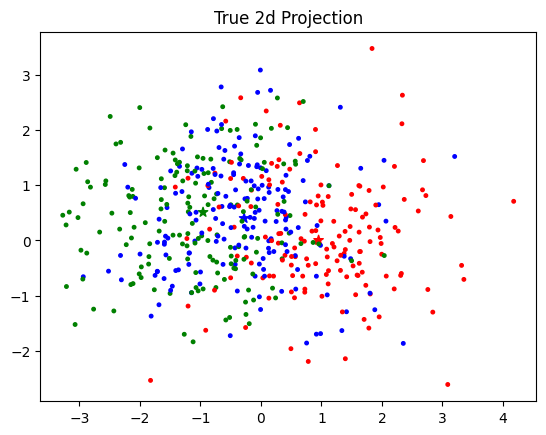

In [205]:
TP = np.zeros((d,dk))
TP[:dk,:dk] = np.eye(dk)
VisualizingFunctions.visualize(X_train,L_train,components,TP,title= "True 2d Projection")

### Random Projection of Samples on 2-Dimensional Subspace

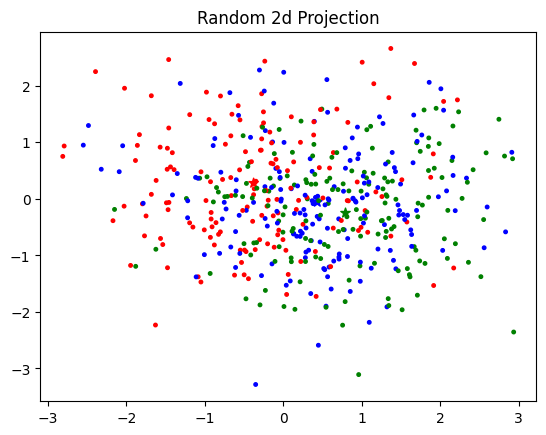

In [206]:
stiefel = pymanopt.manifolds.Stiefel(n = d, p = dk)
RP = stiefel.random_point()

VisualizingFunctions.visualize(X_train,L_train,components,RP,title= "Random 2d Projection")


In [230]:
#Embedding Function
def run(X_train, L_train,d, dk,margin):
    projector = Stiefel(n = d, p = dk)
    triplet_loss_func = AllTripletsFast.TripletLoss(X = X_train, labels = L_train, metric = L2Dist, margin = margin,
                                              embedding = ProjectionEmbedding,manifold = projector,dk = dk)
    (cost, grad,hess) = triplet_loss_func.create_cost_and_grad()
    problem = pymanopt.Problem(
        projector, cost = cost,
                    euclidean_gradient=grad,
                    euclidean_hessian=hess,
    )

    optimizer = ConjugateGradient(verbosity=0,min_step_size=1e-9)

    result = optimizer.run(problem)
    return (result,triplet_loss_func)

In [208]:
# First example
margin = 0.2
(result,loss_class) = run(X_train,L_train,d,dk,margin)
P = result.point

Optimizing...
Iteration    Cost                       Gradient norm     
---------    -----------------------    --------------    
   1         +4.7617970825661488e+07    8.98062518e+06    
   2         +4.1549108174446575e+07    7.24647781e+06    
   3         +3.9843301962956682e+07    6.21882365e+06    
   4         +3.8225579858568572e+07    4.66623074e+06    
   5         +3.7067483792668469e+07    3.13646205e+06    
   6         +3.6641495126477063e+07    1.90316678e+06    
   7         +3.6412602662560590e+07    9.66609624e+05    
   8         +3.6373166694506429e+07    7.40101049e+05    
   9         +3.6312329501899801e+07    5.24924182e+05    
  10         +3.6292140480681151e+07    6.18077820e+05    
  11         +3.6273115839408420e+07    3.13765697e+05    
  12         +3.6269854869658291e+07    2.03830488e+05    
  13         +3.6266275597153977e+07    1.69822961e+05    
  14         +3.6264085573367462e+07    1.74225440e+05    
  15         +3.6263021683725797e+07    6.

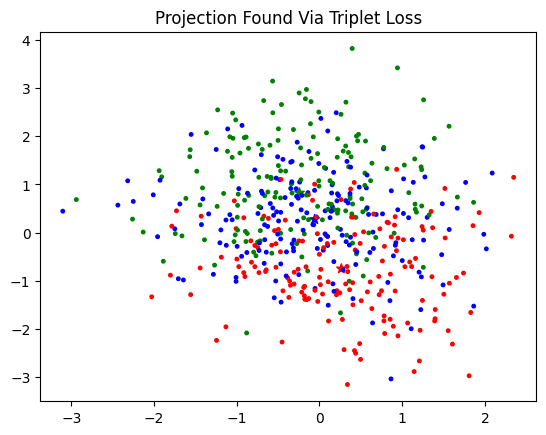

In [209]:
VisualizingFunctions.visualize(X_train,L_train,components,P,title = "Projection Found Via Triplet Loss")

In [213]:
from MainFunctions import Prediction
X_test,L_test = GMMD.generate_GMM_samples(components = components,n_samples = 1000,sigma= sigma)
print("Random Projection:", Prediction.accuracy(X_test,L_test,X_train,L_train,embed_all = ProjectionEmbedding.embed_all,P = RP,metric = L2Dist))
print("True Projection:", Prediction.accuracy(X_test,L_test,X_train,L_train,embed_all = ProjectionEmbedding.embed_all,P = TP,metric = L2Dist))
print("Our Projection:", Prediction.accuracy(X_test,L_test,X_train,L_train,embed_all = ProjectionEmbedding.embed_all,P = P,metric = L2Dist))

Random Projection: 0.505
True Projection: 0.625
Our Projection: 0.589


## Role of Margin

In [229]:
margins = np.linspace(0,10,30)

k = 4 #number of components
dk = 2 # dimension of components
d = 10 # dimension of samples
n = 100 #number of samples
sigma = 1 #sigma, noise size. Rmk, this is the width of the noise over the width of the mean separation roughly.

components = GMMD.generate_GMM_means(n_components=k,dim_samples= d, dim_components=dk)
X_train,L_train = GMMD.generate_GMM_samples(components = components,n_samples = n,sigma= sigma)

P_vals = []

[ 0.          0.34482759  0.68965517  1.03448276  1.37931034  1.72413793
  2.06896552  2.4137931   2.75862069  3.10344828  3.44827586  3.79310345
  4.13793103  4.48275862  4.82758621  5.17241379  5.51724138  5.86206897
  6.20689655  6.55172414  6.89655172  7.24137931  7.5862069   7.93103448
  8.27586207  8.62068966  8.96551724  9.31034483  9.65517241 10.        ]


In [231]:
for idx,margin in enumerate(margins):
    P_vals.append(run(X_train,L_train,d,dk,margin)[0].point)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


### The Role of Margin

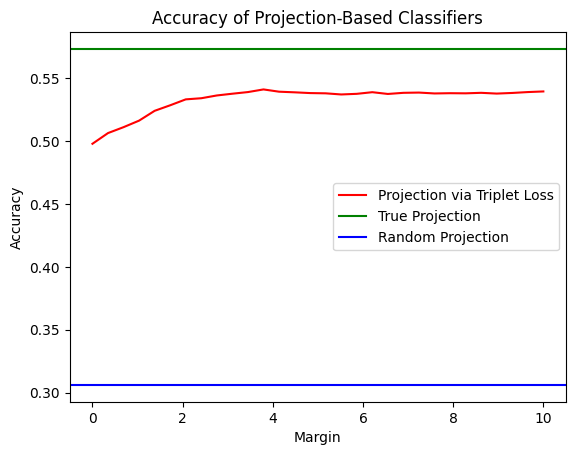

In [237]:
X_test,L_test = GMMD.generate_GMM_samples(components = components,n_samples = 10000,sigma= sigma)

rp_manifold = Stiefel(n = d, p = dk)
RP = rp_manifold.random_point()
random_projection_classifier_accuracy = Prediction.accuracy(X_test,L_test,X_train,L_train,embed_all = ProjectionEmbedding.embed_all,P = RP,metric = L2Dist)


TP  = np.zeros((d,dk))
TP[:dk,:dk] = np.eye(dk)
true_projection_classifier_accuracy = Prediction.accuracy(X_test,L_test,X_train,L_train,embed_all = ProjectionEmbedding.embed_all,P = TP,metric = L2Dist)

triplet_projection_accuracies = [Prediction.accuracy(X_test,L_test,X_train,L_train,embed_all = ProjectionEmbedding.embed_all,P = P,metric = L2Dist) for P in P_vals]

plt.plot(margins, triplet_projection_accuracies, label = "Projection via Triplet Loss",color = "red")

plt.axhline(y = true_projection_classifier_accuracy, xmin = min(margins), xmax = max(margins), label = "True Projection",color = "green")

plt.axhline(y = random_projection_classifier_accuracy, xmin = min(margins), xmax = max(margins), label = "Random Projection",color = "blue")

plt.title("Accuracy of Projection-Based Classifiers")
plt.xlabel("Margin")
plt.ylabel("Accuracy")
plt.legend()

### The Role of Sampels

In [262]:
k = 4  #number of components
dk = 2  # dimension of components
d = 10  # dimension of samples
n_vals = [2**i for i in range(2,12)]
n_max = n_vals[-1]
sigma = 1  #sigma, noise size. Rmk, this is the width of the noise over the width of the mean separation roughly.

components = GMMD.generate_GMM_means(n_components=k, dim_samples=d, dim_components=dk)
X_train, L_train = GMMD.generate_GMM_samples(components=components, n_samples=n_max, sigma=sigma)

In [263]:
P_vals = []
for idx,n in enumerate(n_vals):
    print(n)
    P_vals.append(run(X_train[:n,:],L_train[:n],d,dk,margin = 2)[0].point)

4
8
16
32
64
128
256
512
1024
2048


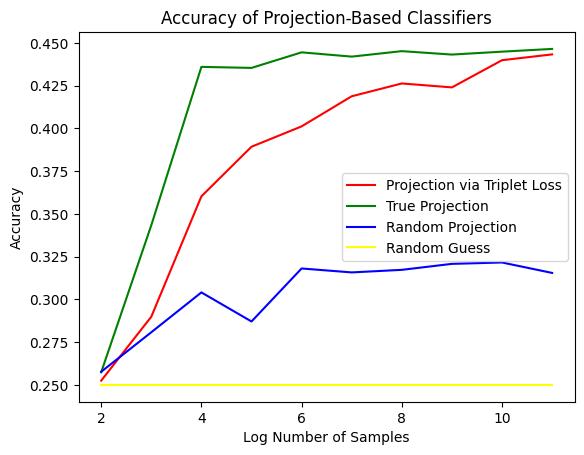

In [266]:
X_test,L_test = GMMD.generate_GMM_samples(components = components,n_samples = 10000,sigma= sigma)

rp_manifold = Stiefel(n = d, p = dk)
RP = rp_manifold.random_point()
random_projection_classifier_accuracy = [Prediction.accuracy(X_test,L_test,X_train[:n,:],L_train[:n],embed_all = ProjectionEmbedding.embed_all,P = RP,metric = L2Dist) for _,n in enumerate(n_vals)]


TP  = np.zeros((d,dk))
TP[:dk,:dk] = np.eye(dk)
true_projection_classifier_accuracy = [Prediction.accuracy(X_test,L_test,X_train[:n,:],L_train[:n],embed_all = ProjectionEmbedding.embed_all,P = TP,metric = L2Dist) for _,n in enumerate(n_vals)]

triplet_projection_accuracies = [Prediction.accuracy(X_test,L_test,X_train[:n,:],L_train[:n],embed_all = ProjectionEmbedding.embed_all,P = P_vals[i],metric = L2Dist) for i,n  in enumerate(n_vals)]

random_guess = [1/k for _,n in enumerate(n_vals)]

plt.plot(np.log2(n_vals), triplet_projection_accuracies, label = "Projection via Triplet Loss",color = "red")

plt.plot(np.log2(n_vals), true_projection_classifier_accuracy, label = "True Projection",color = "green")

plt.plot(np.log2(n_vals), random_projection_classifier_accuracy, label = "Random Projection",color = "blue")

plt.plot(np.log2(n_vals), random_guess, label = "Random Guess",color = "yellow")



plt.title("Accuracy of Projection-Based Classifiers")
plt.xlabel("Log Number of Samples")
plt.ylabel("Accuracy")
plt.legend()
plt.show()